# üìö Project: Customer Segmentation using K-Means

## 1. Problem Statement
- Cluster customers into groups based on Age, Income, and Spending Score.

In [40]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('Mall_Customers.csv')
df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


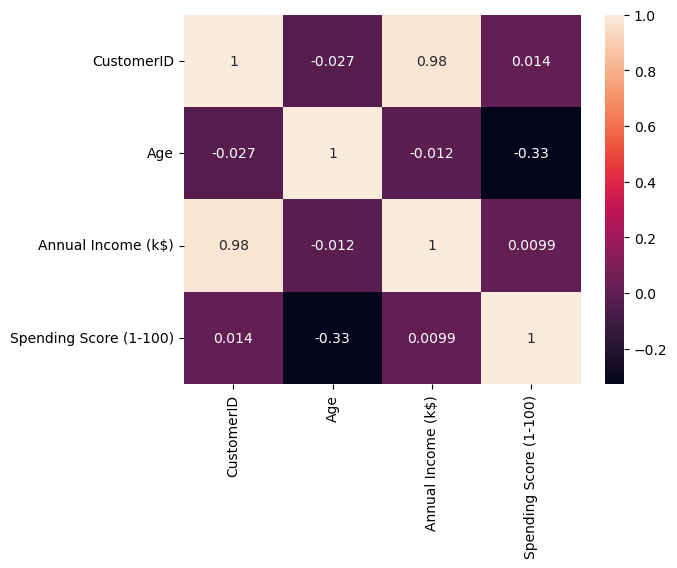

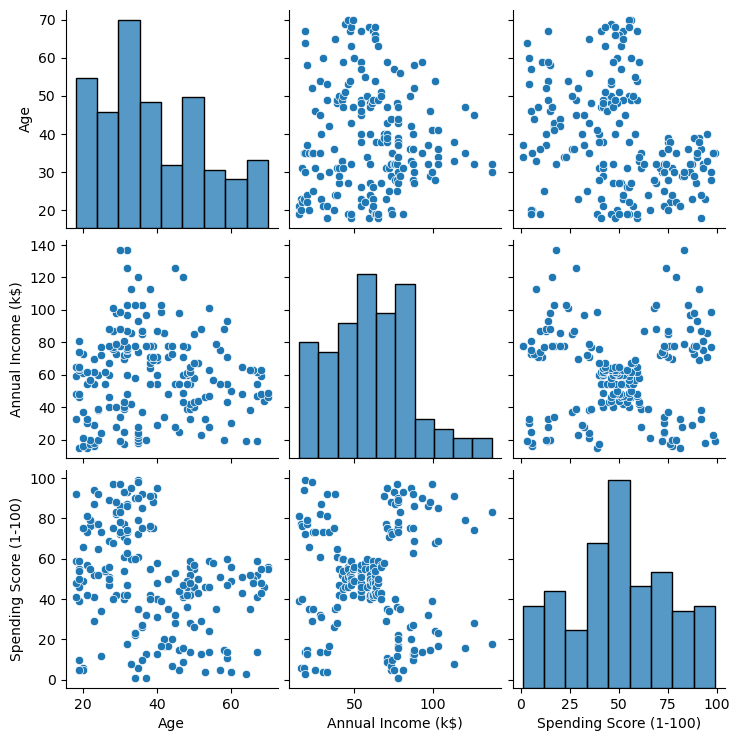

In [41]:
# Basic info
df.info()
df.describe()
# Only select numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Now plot the heatmap
sns.heatmap(numeric_df.corr(), annot=True)

# Check for missing values
df.isnull().sum()

# Visualize features
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
#sns.heatmap(df.corr(), annot=True)#

In [42]:
  # Selecting useful features
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Feature scaling (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

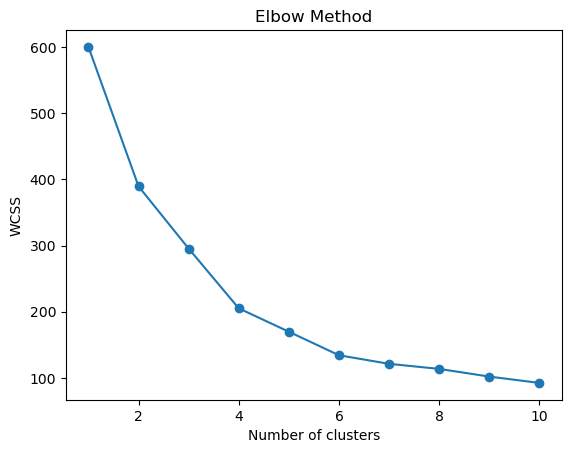

In [43]:
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [44]:
# Choose optimal clusters from Elbow curve, e.g., k=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

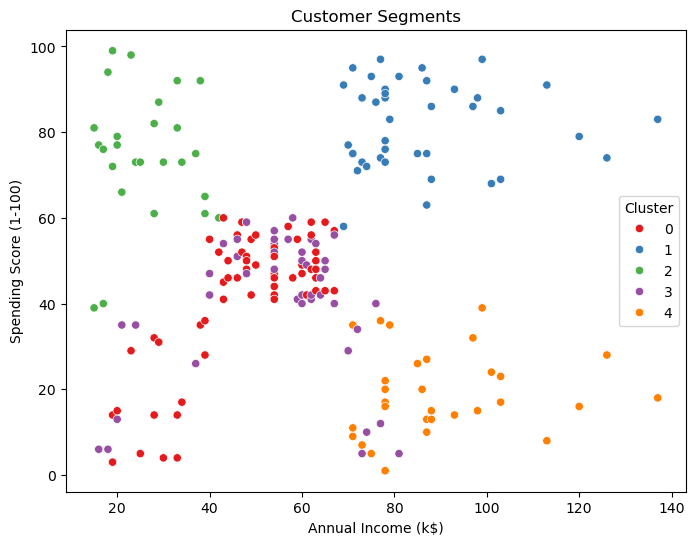

In [45]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', data=df, palette='Set1')
plt.title('Customer Segments')
plt.show()

In [46]:
import plotly.express as px
import pandas as pd

# Load your data (replace with your actual clustered DataFrame)
df = pd.read_csv('Mall_Customers.csv')
df['Cluster'] = clusters  # Add the cluster labels you got from KMeans

# Rename columns if needed (Plotly likes clean names)
df.columns = ['CustomerID', 'Gender', 'Age', 'Annual Income', 'Spending Score', 'Cluster']

# Bubble Plot: Income vs Spending Score with Age as size
fig = px.scatter(
    df,
    x='Annual Income',
    y='Spending Score',
    color='Cluster',
    size='Age',
    hover_data=['Gender'],
    title='Customer Segments by Income, Spending, and Age',
    color_continuous_scale='Viridis'
)
fig.show()


In [47]:
label_map = {
    0: 'Mature Average Spenders',
    1: 'High Value Customers',
    2: 'Young Impulsive Spenders',
    3: 'Standard Young Customers',
    4: 'Wealthy Conservative Customers'
}

df['Segment'] = df['Cluster'].map(label_map)

In [48]:
fig = px.scatter(
    df,
    x='Annual Income',
    y='Spending Score',
    color='Segment',
    size='Age',
    hover_data=['Gender'],
    title='Customer Segments by Income, Spending, and Age',
    color_continuous_scale='Viridis'
)
fig.show()

In [49]:
fig = px.pie(
    df,
    names='Gender',
    title='Gender Distribution of Customers',
    hole=0.4  # donut chart style
)
fig.show()

In [50]:
fig = px.histogram(
    df,
    x='Cluster',
    title='Number of Customers in Each Cluster',
    color='Segment'
)
fig.show()

In [51]:
fig = px.box(
    df,
    x='Cluster',
    y='Spending Score',
    color='Segment',
    title='Spending Distribution per Cluster'
)
fig.show()

In [52]:
df.groupby('Cluster').mean(numeric_only=True)

CustomerID        Age  Annual Income  Spending Score
Cluster                                                      
0         68.775862  55.275862      47.620690       41.706897
1        161.025000  32.875000      86.100000       81.525000
2         23.461538  25.769231      26.115385       74.846154
3         86.377778  26.733333      54.311111       40.911111
4        166.870968  44.387097      89.774194       18.483871

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df[['Annual Income', 'Spending Score', 'Age']])
df['PCA1'], df['PCA2'] = pca_components[:, 0], pca_components[:, 1]


In [54]:
df.groupby('Segment')['Spending Score'].mean() * df['Segment'].value_counts()

Segment
High Value Customers              3261.0
Mature Average Spenders           2419.0
Standard Young Customers          1841.0
Wealthy Conservative Customers     573.0
Young Impulsive Spenders          1946.0
dtype: float64

In [55]:
segment_summary = df.groupby('Segment').agg({
    'Age': 'mean',
    'Annual Income': 'mean',
    'Spending Score': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Customer Count'})

segment_summary = segment_summary.round(1)
display(segment_summary)

Age  Annual Income  Spending Score  \
Segment                                                               
High Value Customers            32.9           86.1            81.5   
Mature Average Spenders         55.3           47.6            41.7   
Standard Young Customers        26.7           54.3            40.9   
Wealthy Conservative Customers  44.4           89.8            18.5   
Young Impulsive Spenders        25.8           26.1            74.8   

                                Customer Count  
Segment                                         
High Value Customers                        40  
Mature Average Spenders                     58  
Standard Young Customers                    45  
Wealthy Conservative Customers              31  
Young Impulsive Spenders                    26

In [56]:
revenue_estimate = df.groupby('Segment')['Spending Score'].mean() * df['Segment'].value_counts()
revenue_estimate = revenue_estimate.round(2)
print(revenue_estimate)

Segment
High Value Customers              3261.0
Mature Average Spenders           2419.0
Standard Young Customers          1841.0
Wealthy Conservative Customers     573.0
Young Impulsive Spenders          1946.0
dtype: float64


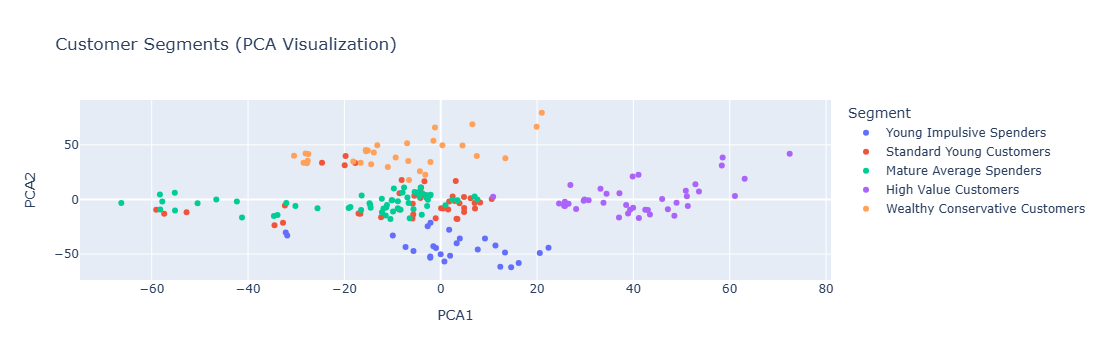

In [57]:
from sklearn.decomposition import PCA
import plotly.express as px

features = ['Annual Income', 'Spending Score', 'Age']
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[features])
df['PCA1'], df['PCA2'] = pca_result[:, 0], pca_result[:, 1]

fig = px.scatter(
    df, x='PCA1', y='PCA2', color='Segment',
    title='Customer Segments (PCA Visualization)',
    hover_data=['Age', 'Annual Income', 'Spending Score']
)
fig.show()

üßç‚Äç‚ôÇÔ∏èüìë Customer Personas
1Ô∏è‚É£ High Value Customers
üë• Count: 40

üë§ Avg Age: 32.9

üí∞ Income: $86.1k

üõçÔ∏è Spending: 81.5

üß† Persona:
Young professionals with high income and high spending. Likely tech-savvy, brand-conscious, and responsive to loyalty rewards and premium offerings.

üéØ Strategy:

Prioritize for VIP loyalty programs

Offer premium upgrades and early access

Upsell high-end products

2Ô∏è‚É£ Mature Average Spenders
üë• Count: 58

üë§ Avg Age: 55.3

üí∞ Income: $47.6k

üõçÔ∏è Spending: 41.7

üß† Persona:
Older, stable customers with moderate income and spending. Value-conscious and possibly brand-loyal.

üéØ Strategy:

Promote value bundles and seasonal offers

Consider personalized recommendations

Engage via email/newsletters

3Ô∏è‚É£ Standard Young Customers
üë• Count: 45

üë§ Avg Age: 26.7

üí∞ Income: $54.3k

üõçÔ∏è Spending: 40.9

üß† Persona:
Young working adults with average income and moderate spending. Might be occasional or pragmatic shoppers.

üéØ Strategy:

Introduce flash sales, time-limited discounts

Push mobile/app-based engagement

Monitor for potential upgrade to high spenders

4Ô∏è‚É£ Wealthy Conservative Customers
üë• Count: 31

üë§ Avg Age: 44.4

üí∞ Income: $89.8k

üõçÔ∏è Spending: 18.5

üß† Persona:
High-income but low-spending customers. Possibly cautious or brand-agnostic.

üéØ Strategy:

Educate on premium product value

Use testimonials, quality assurance

Test luxury subscription or trial options

5Ô∏è‚É£ Young Impulsive Spenders
üë• Count: 26

üë§ Avg Age: 25.8

üí∞ Income: $26.1k

üõçÔ∏è Spending: 74.8

üß† Persona:
Low-income but high-spending ‚Äî likely trend-driven, social media influenced, and impulsive.

üéØ Strategy:

Promote with flash deals and gamified discounts

Leverage influencers or social commerce

Upsell affordable high-margin products

üí∞üìä Revenue Impact Analysis

Segment	Est. Revenue Potential
High Value Customers	$3,261
Mature Average Spenders	$2,419
Young Impulsive Spenders	$1,946
Standard Young Customers	$1,841
Wealthy Conservative Customers	$573

‚úÖ Insights:

Cluster 1: High Value Customers drive the most potential revenue ‚Äî top priority!

Young Impulsive Spenders (Cluster 2) punch above their weight ‚Äî invest in retention.

Wealthy Conservatives show the lowest ROI ‚Äî consider re-engagement tactics.